In [41]:
from __future__ import print_function
import os
import json
import argparse
import statistics
import numpy as np
import pickle
import torch
from collections import Counter
import time
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import submodlib
import re
from submodlib.helper import create_kernel
from submodlib.functions.facilityLocationMutualInformation import (
    FacilityLocationMutualInformationFunction,
)
from submodlib.functions.facilityLocationVariantMutualInformation import (
    FacilityLocationVariantMutualInformationFunction,
)
from submodlib.functions.graphCutMutualInformation import (
    GraphCutMutualInformationFunction,
)
from submodlib.functions.logDeterminantMutualInformation import (
    LogDeterminantMutualInformationFunction,
)

from sklearn import preprocessing

In [42]:
def budget(budget_size):
    return int(4.92 * budget_size)


In [43]:
def normalize(lst):
    return [(val - lst[-1]) / (lst[0] - lst[-1]) for val in lst]

def normalize_derivatives(derv):
    arr = np.array(derv)
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    


In [44]:
def second_derivative(lst):
    temp_lst = [lst[0]] + [_ for _ in lst]
    temp_lst.extend([temp_lst[-1]])
    length = len(lst)
    res = [temp_lst[ind + 1] - 2 * temp_lst[ind] + temp_lst[ind - 1] for ind in range(1, len(lst) + 1)]
    return res

print(second_derivative([-4,-2,-1,0,1,2,4,8,6,45,2,3]))

[2, -1, 0, 0, 0, 1, 2, -6, 41, -82, 44, -1]


In [45]:
def compute_subset(
    dirs,
    base_dir,
    query_dir,
    ground_list,
    ground_features,
    ground_features_Y,
    query_list,
    query_features,
    test_features,
    greedyList,
    budget_size,
    target_size,
    accent,
    fxn,
    similarity,
    etaValue,
    feature_type,
    right_end=-1,
    left_end=50,
):
    #     print(greedyList)
    list_total_selection, list_total_count, list_total_duration = [], [], []
    list_accent_sample_count, list_accent_sample_duration = [], []
    #     output_dir = os.path.join(
    #         base_dir,
    #         query_dir,
    #         f'TSS_output/all/budget_{budget_size}/target_{target_size}/{fxn}/eta_{etaValue}/{similarity}/{feature_type}'
    #     )   ------>
    #     os.makedirs(output_dir, exist_ok=True)
    #     for i in [1, 2, 3]:
    for i in [1]:
        run = f"run_{i}"
        #         run_dir = os.path.join(output_dir, run) ------>
        #         for folder in ['train', 'output', 'plots']:
        #             os.makedirs(os.path.join(run_dir, folder), exist_ok=True)

        all_indices = [j[0] for j in greedyList]
        all_gains = [j[1] for j in greedyList]

        def get_accent(ind):
            return re.search(
                "/indicTTS/([A-Za-z_\-]+)/", ground_list[ind]["audio_filepath"]
            ).group(1)

        all_accents = [get_accent(ind) for ind in all_indices]
        #         print(all_accents)
        total_duration, index = 0, 0
        while total_duration + ground_list[all_indices[index]]["duration"] <= budget(
            budget_size
        ):
            total_duration += ground_list[all_indices[index]]["duration"]
            index += 1

        list_total_count.append(index)
        list_total_duration.append(total_duration)
        selected_indices = all_indices[:index]
        selected_gains = all_gains[:index]
        derivatives = second_derivative(selected_gains)[:index]
        selected_accents = all_accents[:index]

        print(Counter(selected_accents))
        #         print("Number of repeated values = ", len(selected_indices) - len(set(selected_indices)))
        #         with open(f'{run_dir}/gains.txt' , 'w') as file:
        #             for ind, (entry, accent) in enumerate(zip(selected_gains, selected_accents)):
        #                 file.write(f"{ind}, {entry}, {accent}\n")
        excluded = left_end
        color_array = [
            "r" if get_accent(ind) == accent else "b" for ind in selected_indices
        ]
        accent_count_array = [
            np.sum(
                [False if acc == accent else True for acc in selected_accents[: i + 1]]
            )
            / (i)
            for i in range(1, 1 + len(selected_gains))
        ]

        plt.scatter(
            left_end + np.arange(len(selected_gains[left_end:right_end])),
            normalize(selected_gains[left_end:right_end]),
            c=color_array[left_end:right_end],
            s=5,
            marker=".",
            label="scatter"
        )
        plt.plot(
            left_end + np.arange(len(selected_gains[left_end:right_end])),
            accent_count_array[left_end:right_end],
            "orange",
            label="outside_accent_percent"
        )
#         plt.plot(left_end + np.arange(len(derivatives[left_end:right_end])),normalize_derivatives(derivatives[left_end:right_end]), "green", label="curvature")
        plt.xlabel("sample number")
        plt.ylabel("selected gains")
        # plt.title(f"gains graph excluding left = {left_end}, right = {right_end}: Linear scale")
        plt.title(
            f"gains graph  left: {left_end}, right: {right_end}, scale: Linear, run: {i}, accent={accent}, fn = {fxn}"
        )
        # plt.yscale("log")
        #         plt.xscale("log")
        plt.show()

        #         excluded = 0
        #         color_array = ['r' if get_accent(ind) == accent else 'b' for ind in selected_indices[excluded:]]
        #         plt.scatter(excluded + np.arange(len(selected_gains[excluded:])), selected_gains[excluded:], c=color_array)
        #         plt.xlabel("sample number")
        #         plt.ylabel("selected gains")
        #         plt.title(f"gains graph excluded = {excluded} scale = Linear run = {i} accent={accent} fn = {fxn}")
        #         plt.show()

        selected_list = [ground_list[j] for j in selected_indices]

        #        train_list = selected_list + query_list
        train_list = selected_list

        accent_sample_count, accent_sample_duration = 0, 0
        for item in selected_list:
            if item["audio_filepath"].split("/")[-4] == accent:
                accent_sample_count += 1
                accent_sample_duration += item["duration"]
        list_accent_sample_count.append(accent_sample_count)
        list_accent_sample_duration.append(accent_sample_duration)
        list_total_selection.append(
            Counter([item["audio_filepath"].split("/")[-4] for item in selected_list])
        )

    #        with open(base_dir + query_dir + f'train/error_model/{budget_size}/seed_{i}/train.json', 'w') as f:
    #            for line in train_list:
    #                f.write('{}\n'.format(json.dumps(line)))
    #         with open(f'{run_dir}/train/train.json', 'w') as f:
    #             for line in train_list:
    #                 f.write('{}\n'.format(json.dumps(line)))

    #        plots(dirs, run_dir, ground_features, ground_features_Y, query_features, test_features, selected_indices, selected_gains, fxn)

    print("\n subset computed .... \n")
    stats = (
        "total selection : "
        + " ".join(map(str, list_total_count))
        + " -> {0:.2f}\n".format(statistics.mean(list_total_count))
    )
    stats += (
        "total selection duration: "
        + " ".join(map(str, list_total_duration))
        + " -> {0:.2f}\n".format(statistics.mean(list_total_duration))
    )
    stats += (
        "accented selection: "
        + " ".join(map(str, list_accent_sample_count))
        + " -> {0:.2f}\n".format(statistics.mean(list_accent_sample_count))
    )
    stats += (
        "accented duration: "
        + " ".join(map(str, list_accent_sample_duration))
        + " -> {0:.2f}\n".format(statistics.mean(list_accent_sample_duration))
    )
    stats += "\nall selections: " + str(list_total_selection)


#     with open(output_dir + '/stats.txt', 'w') as f:
#         f.write(stats)


In [46]:
def generate_greedyList(
    ground_kernel, query_kernel, query_query_kernel, fxn, budget_size, etaValue
):
    print(f"\ncreating {fxn} object\n")
    if fxn == "FL1MI":
        obj1 = FacilityLocationMutualInformationFunction(
            n=len(ground_kernel),
            num_queries=query_kernel.shape[1],
            query_sijs=query_kernel,
            data_sijs=ground_kernel,
            magnificationEta=etaValue,
        )
    elif fxn == "FL2MI":
        obj1 = FacilityLocationVariantMutualInformationFunction(
            n=len(ground_kernel),
            num_queries=query_kernel.shape[1],
            query_sijs=query_kernel,
            queryDiversityEta=etaValue,
        )
    elif fxn == "GCMI":
        obj1 = GraphCutMutualInformationFunction(
            n=len(ground_kernel),
            num_queries=query_kernel.shape[1],
            query_sijs=query_kernel,
        )
    elif fxn == "LogDMI":
        obj1 = LogDeterminantMutualInformationFunction(
            n=len(ground_kernel),
            num_queries=query_kernel.shape[1],
            lambdaVal=1,
            query_sijs=query_kernel,
            data_sijs=ground_kernel,
            query_query_sijs=query_query_kernel,
            magnificationEta=etaValue,
        )
    else:
        print("\n\n\n............... ERROR not a valid FUNCTION ............\n\n\n")
        exit()
    # print(f"\n{fxn} object created\n")
    # print("\ngenerating greedyList...\n")
    greedyList = obj1.maximize(
        budget=3 * budget_size,
        optimizer="LazyGreedy",
        stopIfZeroGain=False,
        stopIfNegativeGain=False,
        epsilon=0.1,
        verbose=False,
        show_progress=True
    )
    # print("\n.... greedyList generated ... \n")
    return greedyList


In [47]:
def load_features(file_dir, feature_type):
    features = []
    par_dir = os.path.dirname(file_dir)
    file_name = os.path.basename(file_dir)
    new_par_dir = os.path.join(par_dir, "39")
    new_file_name = file_name.replace(".json", f"_{feature_type}.file")
    new_path = os.path.join(new_par_dir, new_file_name)
    with open(new_path, "rb") as f:
        while True:
            try:
                features.append(pickle.load(f))
            except EOFError:
                break
    features = np.concatenate(features, axis=0)
    # print(features.shape)
    return features


In [48]:
def preprocess(base_dir, target_size, budget_size, accent, similarity, feature_type):
    dirs = [
        "kannada_male_english",
        "malayalam_male_english",
        "rajasthani_male_english",
        "hindi_male_english",
        "tamil_male_english",
        "gujarati_female_english",
        "manipuri_female_english",
        "assamese_female_english",
    ]

    query_dir = f"{accent}/"
    query_file_path = base_dir + query_dir + "seed.json"
    query_list = [json.loads(line.strip()) for line in open(query_file_path)]
    query_features = load_features(query_file_path, feature_type)
    query_list, query_features = query_list[:target_size], query_features[:target_size]

    ground_list, ground_list_Y, ground_features = [], [], []
    for i, _dir in enumerate(dirs):
        selection_file_path = base_dir + _dir + "/" + "selection.json"
        selection_file_list = [
            json.loads(line.strip()) for line in open(selection_file_path)
        ]
        ground_list.extend(selection_file_list)
        ground_features.append(load_features(selection_file_path, feature_type))
        ground_list_Y.extend([i] * len(selection_file_list))
    ground_features = np.concatenate(ground_features, axis=0)
    ground_features_Y = np.asarray(ground_list_Y).reshape(-1, 1)

    ### test file
    test_file_path = base_dir + query_dir + "test.json"
    test_list = [json.loads(line.strip()) for line in open(test_file_path)]
    test_features = load_features(test_file_path, feature_type)

    # print(len(ground_list), ground_features.shape)
    # print(len(query_list), query_features.shape)
    # print(len(test_list), test_features.shape)

    # print("creating kernels ....")
    t1 = time.time()
    ground_kernel = create_kernel(ground_features, metric=similarity, mode="dense")
    query_kernel = create_kernel(
        query_features, metric=similarity, mode="dense", X_rep=ground_features
    )
    query_query_kernel = create_kernel(
        query_features, metric=similarity, mode="dense", X_rep=query_features
    )
    t2 = time.time()
    # print("kernel creation done ....", t2 - t1)

    # print("ground_kernel: ", ground_kernel.shape)
    # print("query_kernel: ", query_kernel.shape)
    # print("query_query_kernel: ", query_query_kernel.shape)

    return (
        dirs,
        query_dir,
        ground_list,
        ground_features,
        ground_features_Y,
        ground_kernel,
        query_list,
        query_features,
        query_kernel,
        query_query_kernel,
        test_features,
    )


In [49]:
def get_plots(
    budget_size,
    target_size,
    etaValue,
    similarity,
    fxn,
    accent,
    feature_type,
    left_end=50,
    right_end=-1,
):
    base_dir = "../../data/"

    (
        dirs,
        query_dir,
        ground_list,
        ground_features,
        ground_features_Y,
        ground_kernel,
        query_list,
        query_features,
        query_kernel,
        query_query_kernel,
        test_features,
    ) = preprocess(base_dir, target_size, budget_size, accent, similarity, feature_type)

    greedyList = generate_greedyList(
        ground_kernel, query_kernel, query_query_kernel, fxn, budget_size, etaValue
    )
    compute_subset(
        dirs,
        base_dir,
        query_dir,
        ground_list,
        ground_features,
        ground_features_Y,
        query_list,
        query_features,
        test_features,
        greedyList,
        budget_size,
        target_size,
        accent,
        fxn,
        similarity,
        etaValue,
        feature_type,
        left_end=left_end,
        right_end=right_end,
    )



creating FL2MI object

Counter({'assamese_female_english': 5765, 'manipuri_female_english': 4411, 'tamil_male_english': 1159, 'gujarati_female_english': 619, 'kannada_male_english': 8, 'malayalam_male_english': 1})


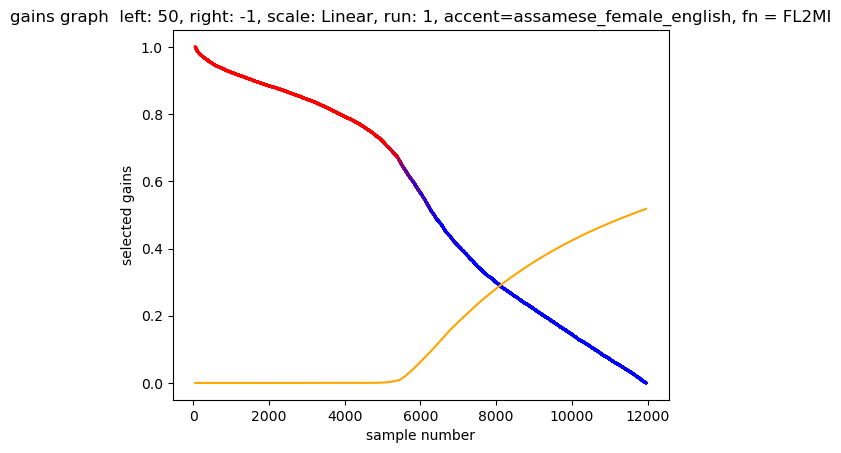


 subset computed .... 


creating GCMI object

Counter({'assamese_female_english': 5740, 'manipuri_female_english': 4444, 'tamil_male_english': 954, 'gujarati_female_english': 672, 'kannada_male_english': 13, 'malayalam_male_english': 4})


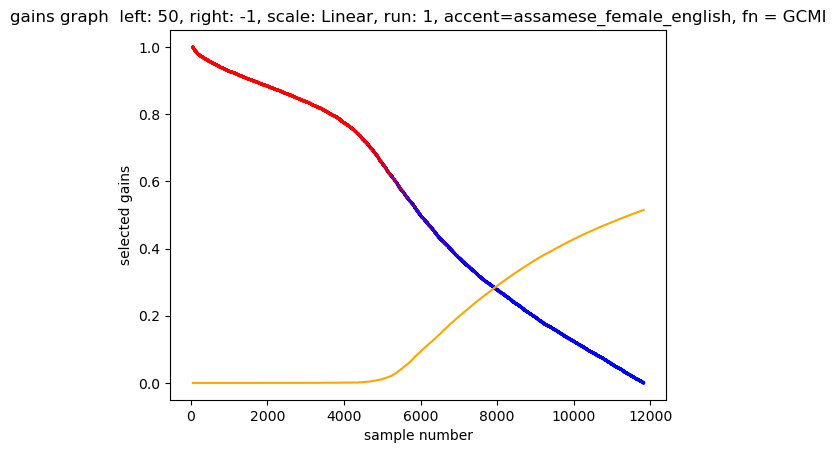


 subset computed .... 



In [50]:
get_plots(
    11000, 20, 1.0, "cosine", "FL2MI", "assamese_female_english", "39"
)
get_plots(
    11000, 20, 1.0, "cosine", "GCMI", "assamese_female_english", "39"
)



creating FL2MI object

Counter({'manipuri_female_english': 6722, 'tamil_male_english': 3213, 'assamese_female_english': 2078, 'gujarati_female_english': 362, 'kannada_male_english': 62, 'malayalam_male_english': 39, 'rajasthani_male_english': 6, 'hindi_male_english': 2})


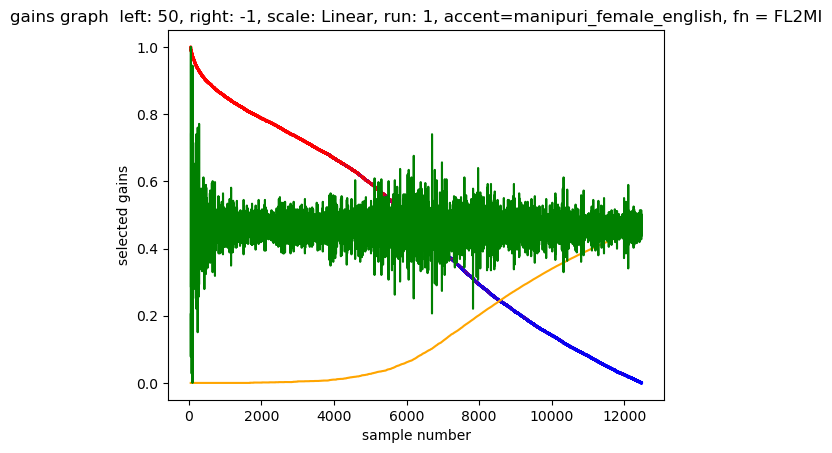


 subset computed .... 


creating GCMI object

Counter({'manipuri_female_english': 6429, 'tamil_male_english': 2844, 'assamese_female_english': 2150, 'gujarati_female_english': 384, 'kannada_male_english': 247, 'malayalam_male_english': 124, 'hindi_male_english': 4, 'rajasthani_male_english': 2})


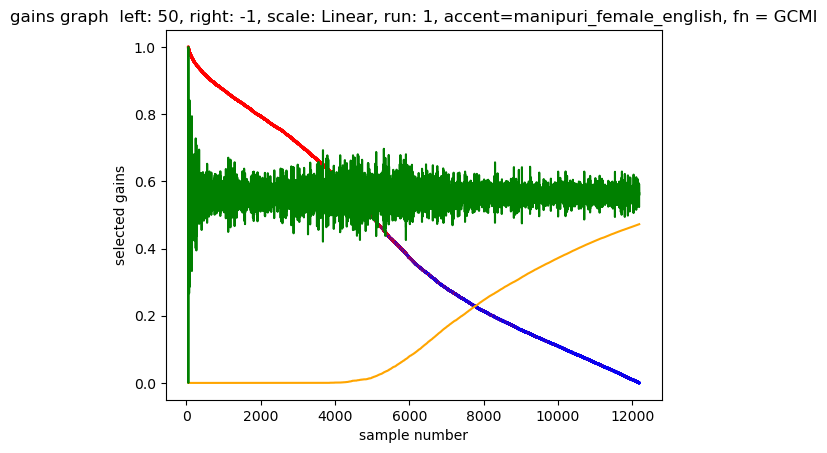


 subset computed .... 



In [34]:
get_plots(
    11000, 20, 1.0, "cosine", "FL2MI", "manipuri_female_english", "39"
)
get_plots(
    11000, 20, 1.0, "cosine", "GCMI", "manipuri_female_english", "39"
)



creating FL2MI object

Counter({'kannada_male_english': 3242, 'malayalam_male_english': 2863, 'tamil_male_english': 1707, 'manipuri_female_english': 1007, 'hindi_male_english': 747, 'gujarati_female_english': 459, 'rajasthani_male_english': 93})


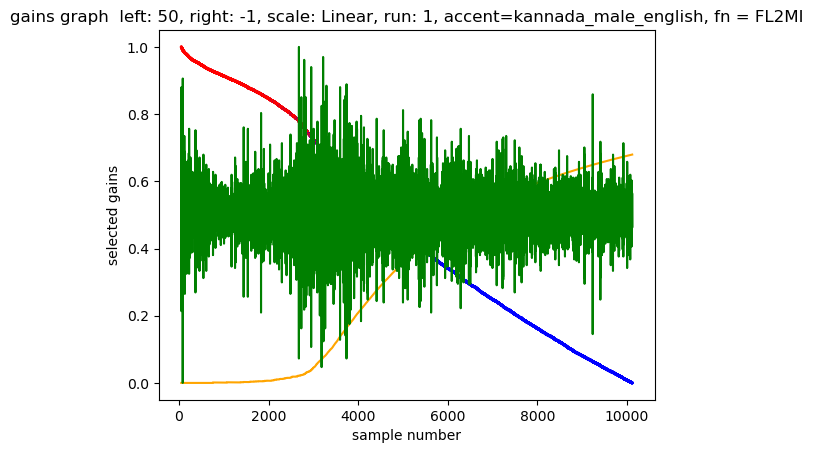


 subset computed .... 


creating GCMI object

Counter({'kannada_male_english': 3239, 'malayalam_male_english': 2799, 'tamil_male_english': 1665, 'manipuri_female_english': 1138, 'hindi_male_english': 725, 'rajasthani_male_english': 464, 'gujarati_female_english': 337})


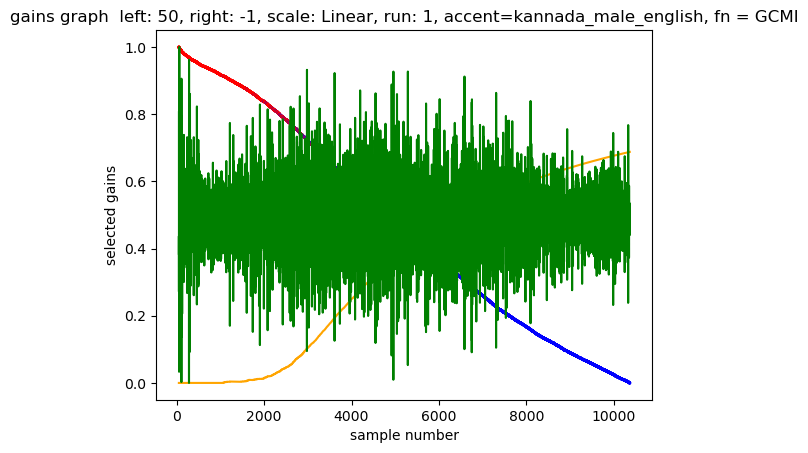


 subset computed .... 



In [35]:
get_plots(
    11000, 20, 1.0, "cosine", "FL2MI", "kannada_male_english", "39"
)
get_plots(
    11000, 20, 1.0, "cosine", "GCMI", "kannada_male_english", "39"
)



creating FL2MI object

Counter({'hindi_male_english': 3365, 'rajasthani_male_english': 2711, 'malayalam_male_english': 2681, 'kannada_male_english': 1370, 'tamil_male_english': 26})


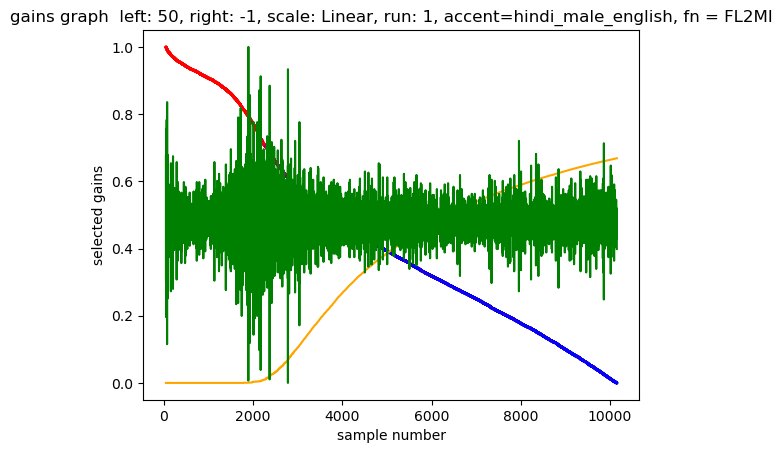


 subset computed .... 


creating GCMI object

Counter({'rajasthani_male_english': 3215, 'hindi_male_english': 2817, 'kannada_male_english': 2171, 'malayalam_male_english': 1871, 'tamil_male_english': 114, 'manipuri_female_english': 8})


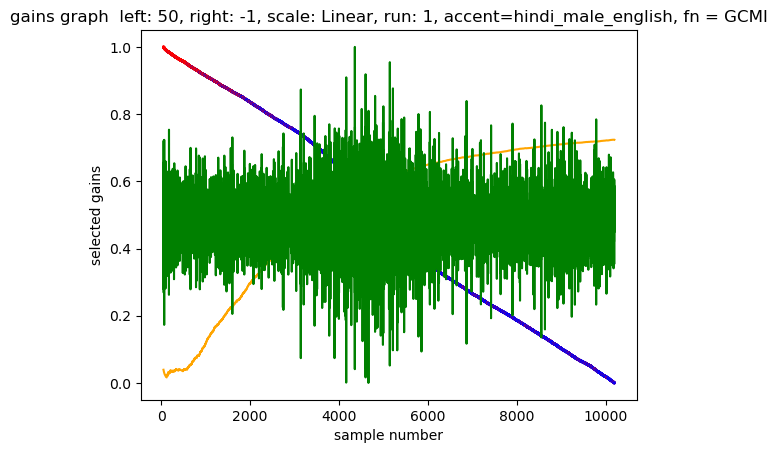


 subset computed .... 



In [36]:
get_plots(
    11000, 20, 1.0, "cosine", "FL2MI", "hindi_male_english", "39"
)
get_plots(
    11000, 20, 1.0, "cosine", "GCMI", "hindi_male_english", "39"
)




creating FL2MI object

Counter({'tamil_male_english': 5161, 'manipuri_female_english': 4228, 'kannada_male_english': 1468, 'malayalam_male_english': 254, 'assamese_female_english': 240, 'gujarati_female_english': 188, 'hindi_male_english': 84, 'rajasthani_male_english': 57})


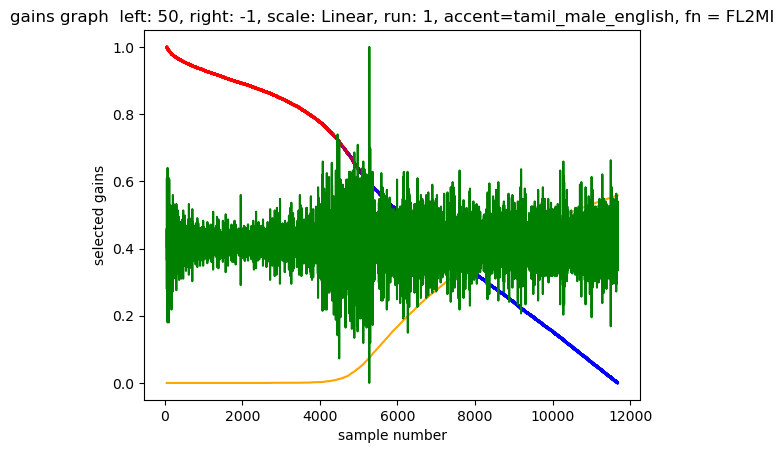


 subset computed .... 


creating GCMI object

Counter({'tamil_male_english': 5099, 'manipuri_female_english': 4797, 'kannada_male_english': 763, 'assamese_female_english': 657, 'gujarati_female_english': 353, 'malayalam_male_english': 137, 'hindi_male_english': 41, 'rajasthani_male_english': 33})


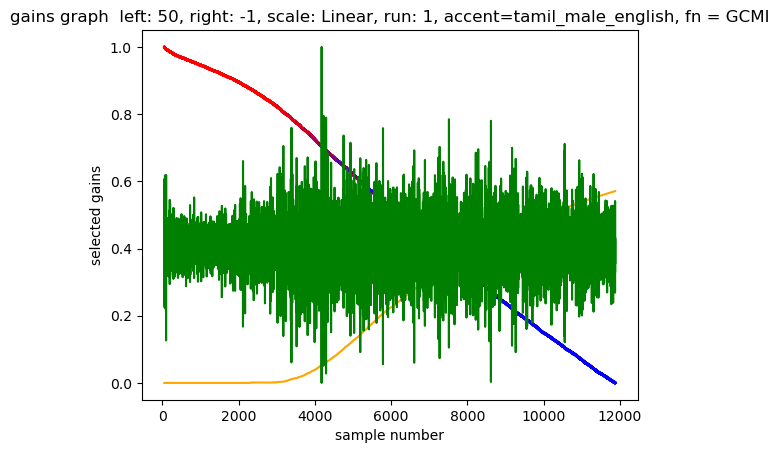


 subset computed .... 



In [37]:
get_plots(
    11000, 20, 1.0, "cosine", "FL2MI", "tamil_male_english", "39"
)
get_plots(
    11000, 20, 1.0, "cosine", "GCMI", "tamil_male_english", "39"
)




creating FL2MI object

Counter({'rajasthani_male_english': 3239, 'hindi_male_english': 2568, 'kannada_male_english': 2133, 'malayalam_male_english': 1227, 'tamil_male_english': 932, 'manipuri_female_english': 148, 'gujarati_female_english': 1})


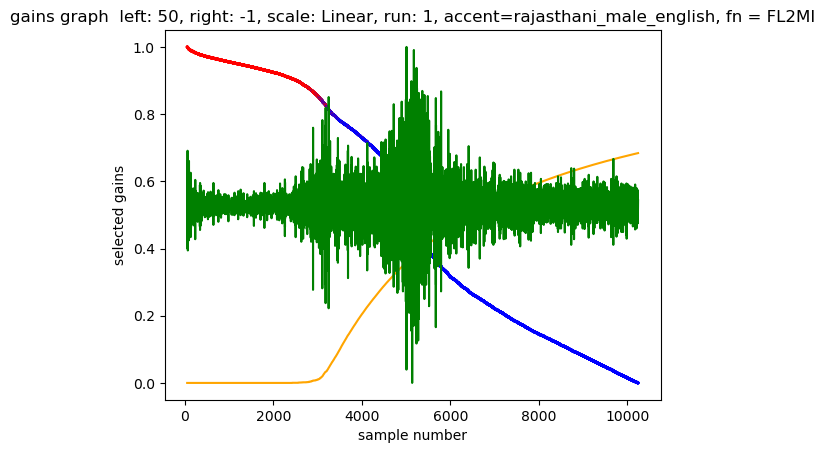


 subset computed .... 


creating GCMI object

Counter({'rajasthani_male_english': 3236, 'hindi_male_english': 2867, 'malayalam_male_english': 1988, 'kannada_male_english': 1938, 'tamil_male_english': 112, 'manipuri_female_english': 19})


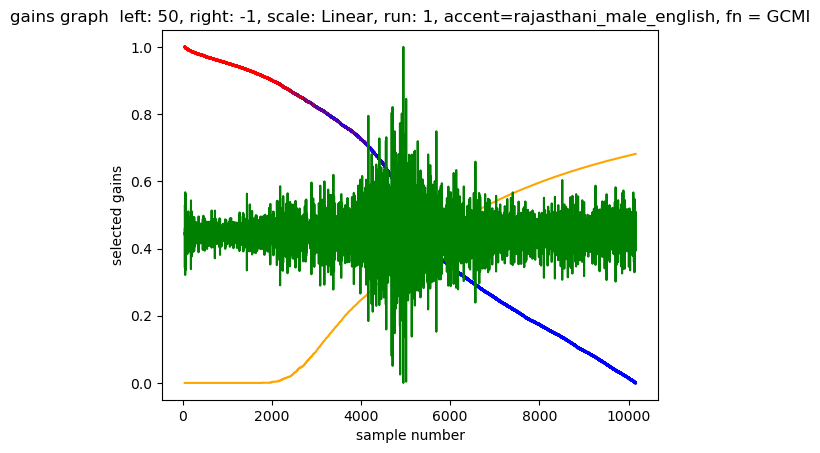


 subset computed .... 



In [38]:
get_plots(
    11000, 20, 1.0, "cosine", "FL2MI", "rajasthani_male_english", "39"
)
get_plots(
    11000, 20, 1.0, "cosine", "GCMI", "rajasthani_male_english", "39"
)




creating FL2MI object

Counter({'malayalam_male_english': 3480, 'kannada_male_english': 3220, 'hindi_male_english': 1436, 'tamil_male_english': 1010, 'rajasthani_male_english': 574, 'manipuri_female_english': 469, 'gujarati_female_english': 77})


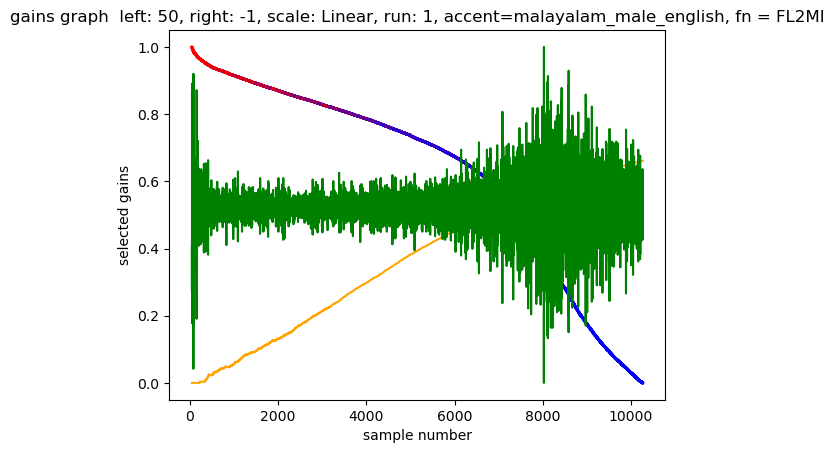


 subset computed .... 


creating GCMI object

Counter({'malayalam_male_english': 3476, 'kannada_male_english': 3187, 'hindi_male_english': 1417, 'rajasthani_male_english': 1200, 'tamil_male_english': 560, 'manipuri_female_english': 340, 'gujarati_female_english': 61})


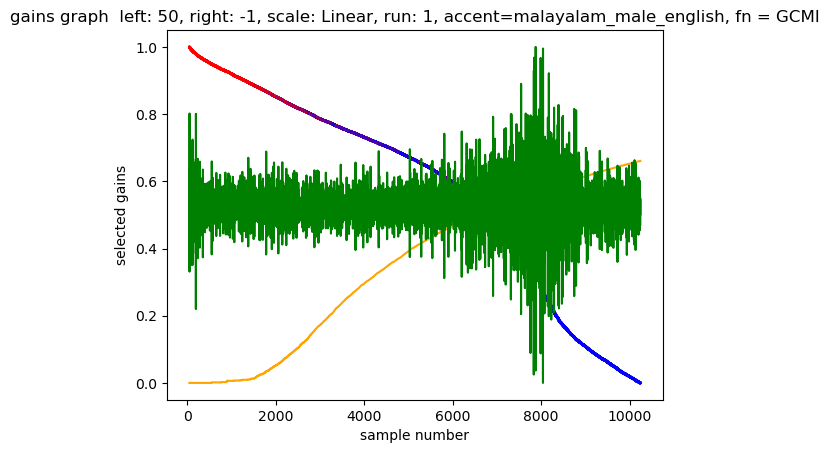


 subset computed .... 



In [39]:
get_plots(
    11000, 20, 1.0, "cosine", "FL2MI", "malayalam_male_english", "39"
)
get_plots(
    11000, 20, 1.0, "cosine", "GCMI", "malayalam_male_english", "39"
)



creating FL2MI object

Counter({'assamese_female_english': 3656, 'gujarati_female_english': 2795, 'manipuri_female_english': 1759, 'kannada_male_english': 980, 'tamil_male_english': 574, 'malayalam_male_english': 136, 'hindi_male_english': 4})


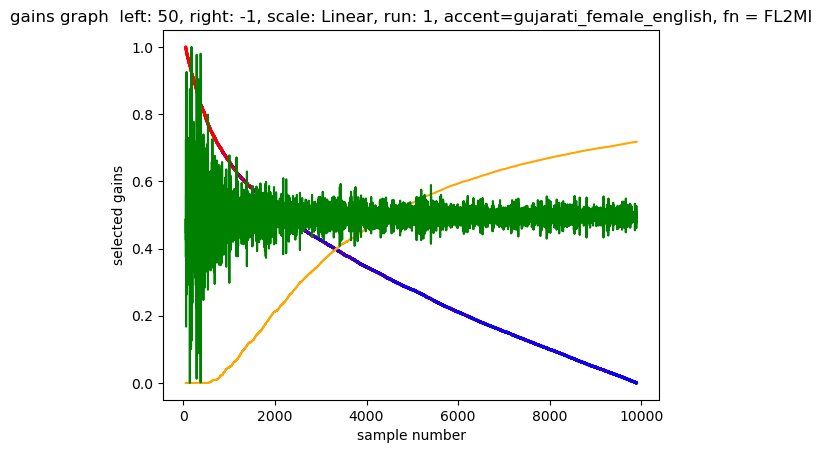


 subset computed .... 


creating GCMI object

Counter({'manipuri_female_english': 3337, 'gujarati_female_english': 2917, 'kannada_male_english': 1989, 'assamese_female_english': 995, 'malayalam_male_english': 891, 'tamil_male_english': 59, 'hindi_male_english': 42, 'rajasthani_male_english': 2})


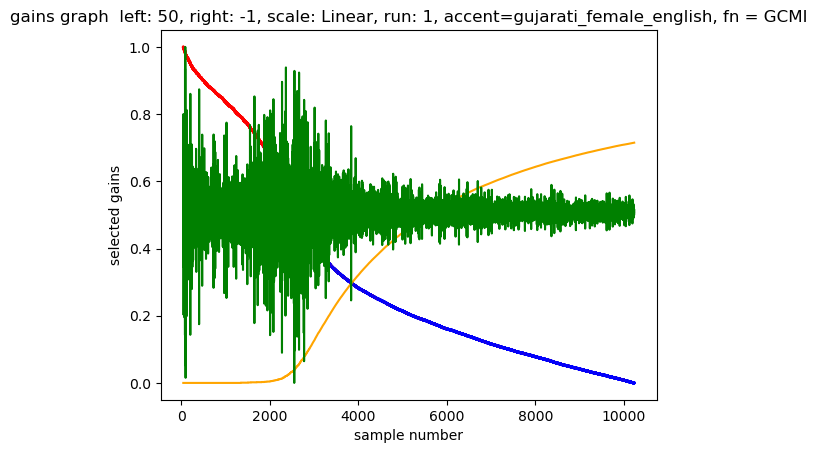


 subset computed .... 



In [40]:
get_plots(
    11000, 20, 1.0, "cosine", "FL2MI", "gujarati_female_english", "39"
)
get_plots(
    11000, 20, 1.0, "cosine", "GCMI", "gujarati_female_english", "39"
)
